In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
from ImplicitDenoising import *
from pykalman import AdditiveUnscentedKalmanFilter

np.random.seed(0)

#
#
noise_percent = 100
#
#

Populating the interactive namespace from numpy and matplotlib


/home/samuel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(0, 1000)

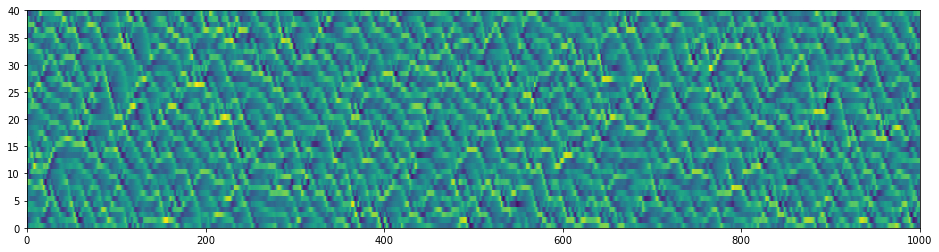

In [2]:
n = 40
F = 16.

def shift(x, s):
    if s == 0: return x
    else: return np.concatenate([x[s:], x[:s]])
    
def L96(x,t,params):
    F = params
    return (shift(x,1)-shift(x,-2))*shift(x,-1)-x+F

# x0 = np.sin(np.arange(n) / np.pi) + np.cos(3*np.pi*np.arange(n))
x0 = np.exp(-(np.arange(n)-n/2)**2 / 16)

t = np.arange(0.0, 60.0, 0.05); dt = t[1]-t[0]
X = odeint(L96, x0, t, (F,))[200:,:].T
t = t[200:]
m = X.shape[1]

figure(figsize = (16,4))
pcolor(X)
xlim(0,m)

In [3]:
noise_level = 0.01*noise_percent*np.var(X)
measurement_noise_gaussian = np.sqrt(noise_level)*np.random.randn(n,m)
Y = X + measurement_noise_gaussian

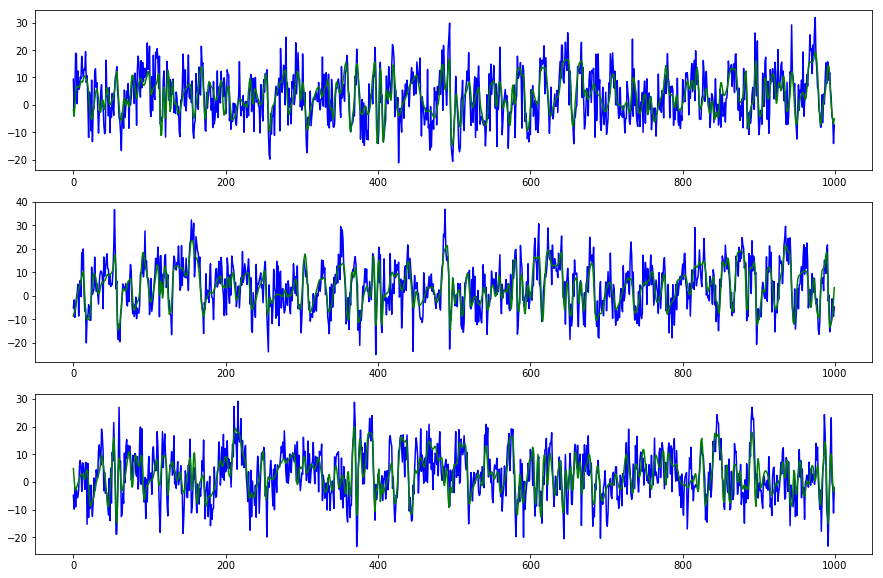

In [4]:
figure(figsize = (15,10))
subplot(3,1,1); plot(Y[0,:], 'b')
subplot(3,1,2); plot(Y[1,:], 'b')
subplot(3,1,3); plot(Y[2,:], 'b')

subplot(3,1,1); plot(X[0,:], 'g')
subplot(3,1,2); plot(X[1,:], 'g')
subplot(3,1,3); plot(X[2,:], 'g')

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

F_hat = tf.get_variable(shape = [1], dtype = tf.float32, name = 'F_hat')

def tf_shift(x, s):
    
    n,m = tf.shape(x).eval()
        
    if s == 0: return x
    elif s>0: return tf.concat([tf.slice(x,[s,0],[n-s,m]),tf.slice(x,[0,0],[s,m])], axis = 0)
    else: return tf.concat([tf.slice(x,[n+s,0],[-s,m]),tf.slice(x,[0,0],[n+s,m])], axis = 0)
        
def tf_L96(x, F = F_hat):
    
    n,m = tf.shape(x).eval()
    return (tf_shift(x,1)-tf_shift(x,-2))*tf_shift(x,-1)-x+F

optimizer, X_hat_tf, cost = create_computational_graph(Y, t, tf_L96, method = 'Gauss3')

init = tf.global_variables_initializer()
sess.run(init)

In [6]:
optimizer.minimize(sess)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.020948
  Number of iterations: 17398
  Number of functions evaluations: 19608


In [7]:
F_hat.eval()

array([15.956859], dtype=float32)

In [8]:
X_hat = X_hat_tf.eval()

/home/samuel/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


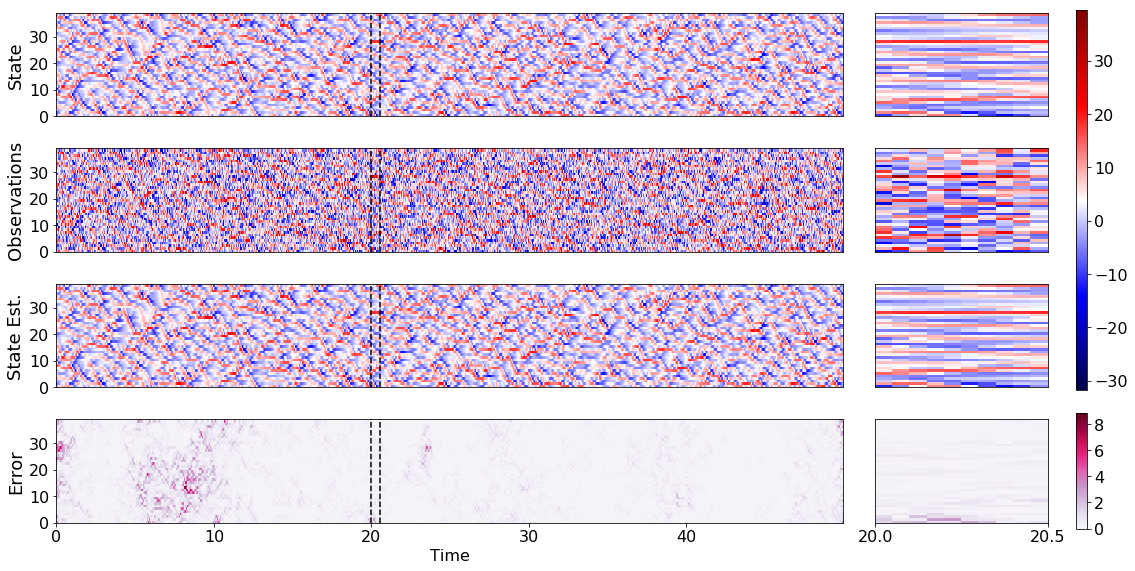

In [9]:
from matplotlib import ticker
fig = figure(figsize = (15,8))

vmax_err = np.max(abs(X-X_hat))
vmax_sol = np.max([Y, X, X_hat])
vmin_sol = np.min([Y, X, X_hat])

cmap = 'seismic' 
err_cmap = 'PuRd'
label_fs = 16

start = 400
end = 411

xx,tt = meshgrid(t-10,np.arange(40))
xs,ts = meshgrid(t[start:end]-10,np.arange(40))

Xticks = [0,10,20,30,40,50]
Yticks = [0,10,20,30]

# State
ax = subplot2grid((4,5),(0, 0), colspan=4, rowspan=1)
obs_plot = pcolor(xx, tt, X, cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
xticks([])
yticks(Yticks, fontsize = label_fs)
ylim([0,39])
ylabel('State', fontsize = label_fs+2)

ax.plot([t[start]-10,t[start]-10],[0,40], 'k--')
ax.plot([t[end]-10,t[end]-10],[0,40], 'k--')

ax = subplot2grid((4,5),(0, 4), colspan=1, rowspan=1)
pcolor(xs, ts, X[:,start:end], cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
xticks([])
yticks([])
ylim([0,39])

# Observations
ax = subplot2grid((4,5),(1, 0), colspan=4, rowspan=1)
pcolor(xx, tt, Y, cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
yticks(Yticks, fontsize = label_fs)
xticks([])
ylim([0,39])
ylabel('Observations', fontsize = label_fs+2)

ax.plot([t[start]-10,t[start]-10],[0,40], 'k--')
ax.plot([t[end]-10,t[end]-10],[0,40], 'k--')

ax = subplot2grid((4,5),(1, 4), colspan=1, rowspan=1)
pcolor(xs, ts, Y[:,start:end], cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
yticks([])
xticks([])
ylim([0,39])

# Implicit denoising state estimate
ax = subplot2grid((4,5),(2, 0), colspan=4, rowspan=1)
pcolor(xx, tt, X_hat, cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
xticks([])
yticks(Yticks, fontsize = label_fs)
ylim([0,39])
ylabel('State Est.', fontsize = label_fs+2)

ax.plot([t[start]-10,t[start]-10],[0,40], 'k--')
ax.plot([t[end]-10,t[end]-10],[0,40], 'k--')

ax = subplot2grid((4,5),(2, 4), colspan=1, rowspan=1)
pcolor(xs, ts, X_hat[:,start:end], cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
xticks([])
yticks([])
ylim([0,39])

# Error
ax = subplot2grid((4,5),(3, 0), colspan=4, rowspan=1)
err_plot = pcolor(xx, tt, abs(X-X_hat), cmap = err_cmap, vmin = 0, vmax = vmax_err)
yticks(Yticks, fontsize = label_fs)
xticks(Xticks, fontsize = label_fs)
ylim([0,39])
ylabel('Error', fontsize = label_fs+2)
xlabel('Time', fontsize = label_fs)

ax.plot([t[start]-10,t[start]-10],[0,40], 'k--')
ax.plot([t[end]-10,t[end]-10],[0,40], 'k--')

ax = subplot2grid((4,5),(3, 4), colspan=1, rowspan=1)
pcolor(xs, ts, abs(X-X_hat)[:,start:end], cmap = err_cmap, vmin = 0, vmax = vmax_err)
yticks([], fontsize = 0)
xticks([t[start]-10,t[end-1]-10], fontsize = label_fs)
ylim([0,39])

position=fig.add_axes([1.,0.08,0.01,0.2])
cb = fig.colorbar(err_plot,cax=position) 
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=label_fs)

position2=fig.add_axes([1.,0.32,0.01,0.66])
cb2 = fig.colorbar(obs_plot,cax=position2) 
cb2.ax.set_yticklabels(cb2.ax.get_yticklabels(), fontsize=label_fs)

tight_layout()